
# Rondom Forest Based Cloud Retrieval
Original developer: Chenxi Wang, UMBC/JCET and NASA/GSFC

Modified by Jianwu Wang for the ML Capacity Development ESDSWG

Last update on 03/2021

Install pandas and tables packages to the latest version. 

The program was tested using pandas version 1.2.3 and tables 3.6.1

You will be asked to RESTART RUNTIME at the end of the installation. Just clicke it the button.

In [ ]:
!pip install pandas --upgrade
!pip install tables --upgrade

     |████████████████████████████████| 9.9MB 6.6MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.3 which is incompatible.
  Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5


     |████████████████████████████████| 4.3MB 6.8MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [ ]:
import sys
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import tables

In [ ]:
print(np.__version__)
print(pd.__version__)
print(tables.__version__)

1.19.5
1.2.3
3.6.1


#Import data from shared Google drive
It will ask you to login using your gmail account. After logging in, an authorization code will be provided. Copy the code and click enter. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls /content/drive/Shareddrives/ML_Capacity_Development_ESDSWG/ML_Capacity_Development_ESDSWG/ML_based_Cloud_Retrieval_Use_Case/


Code/  Data/  Model/  Slides_and_Paper/


In [ ]:
#load dataset
data_set = '/content/drive/Shareddrives/ML_Capacity_Development_ESDSWG/ML_Capacity_Development_ESDSWG/ML_based_Cloud_Retrieval_Use_Case/Data/train_subset_forest.h5'
pd_forest = pd.read_hdf(data_set,key='forest')

In [ ]:
#show data frame structures
print(pd_forest.columns)

Index(['Lon', 'Lat', 'VZA', 'Mu', 'SZA', 'Mu0', 'IGBP', 'SNIC', 'Skin_T',
       'E14', 'E15', 'E16', 'BTS14', 'BTS15', 'BTS16', 'R01', 'R02', 'R03',
       'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R11', 'B12', 'B13',
       'B14', 'B15', 'B16', 'CMASK', 'CPhase', 'VIIRS_CMASK', 'VIIRS_OPPhase',
       'VIIRS_CTPhase'],
      dtype='object')


In [ ]:
# remove bad points and complicated cases
filtered_data_set = pd_forest.loc[
                  ( pd_forest['B12']>100. ) &
                  ( pd_forest['B13']>100. ) &
                  ( pd_forest['B14']>100. ) &
                  ( pd_forest['B15']>100. ) &
                  ( pd_forest['B16']>100. ) &
                  ( pd_forest['B12']<400. ) &
                  ( pd_forest['B13']<400. ) &
                  ( pd_forest['B14']<400. ) &
                  ( pd_forest['B15']<400. ) &
                  ( pd_forest['B16']<400. ) &
                  ( pd_forest['CPhase']!='IOL' ) &
                  ( pd_forest['SZA']<=83 ) &
                  ( pd_forest['SZA']>=0 ) &
                  ( pd_forest['R07']>0.0)
                  ]

In [ ]:
#generate features and labels

t1_X = np.full([len(filtered_data_set),13],0,dtype='f4')
t1_Y = np.full([len(filtered_data_set)],'xxx',dtype='<U3')

t1_X[:, 0] = filtered_data_set.Mu0.values
t1_X[:, 1] = filtered_data_set.Mu.values
t1_X[:, 2] = filtered_data_set.B14.values
t1_X[:, 3] = filtered_data_set.B15.values
t1_X[:, 4] = filtered_data_set.B16.values
t1_X[:, 5] = filtered_data_set.B14.values - filtered_data_set.B15.values
t1_X[:, 6] = filtered_data_set.B15.values - filtered_data_set.B16.values
t1_X[:, 7] = filtered_data_set.R07.values
t1_X[:, 8] = filtered_data_set.R09.values/filtered_data_set.R07.values
t1_X[:, 9] = filtered_data_set.R10.values/filtered_data_set.R07.values
t1_X[:,10] = filtered_data_set.R11.values/filtered_data_set.R07.values
t1_X[:,11] = filtered_data_set.Lat.values
t1_X[:,12] = filtered_data_set.Lon.values
t1_Y = filtered_data_set.CPhase.values

print("features:") 
print(t1_X)
print("labels:")
print(t1_Y)

features:
[[ 9.1219163e-01  7.5068784e-01  2.9444434e+02 ...  2.3842752e-01
   4.0375137e+01 -1.0722393e+02]
 [ 8.1065524e-01  8.9053059e-01  2.6962210e+02 ...  5.7672042e-01
   5.7277084e+01 -6.4945526e+01]
 [ 8.6698371e-01  9.1524118e-01  2.7679770e+02 ...  6.5470445e-01
  -1.0944021e+01 -7.5002884e+01]
 ...
 [ 8.5044408e-01  7.5733709e-01  2.6776901e+02 ...  5.4833764e-01
  -2.8344654e+01  1.5313779e+02]
 [ 4.1421670e-01  8.9195544e-01  2.7173709e+02 ...  4.5762712e-01
   6.6473648e+01 -1.4605330e+02]
 [ 9.0266037e-01  7.5995231e-01  2.9494528e+02 ...  1.8670221e-01
   3.5351654e+01 -8.1041504e+01]]
labels:
['Liq' 'Liq' 'Liq' ... 'Liq' 'Ice' 'Ice']


In [ ]:
# separate the data set into two parts (training 70% and testing 30%)
testing_size = 0.30
seed = 7
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(t1_X,t1_Y,test_size=testing_size,random_state=seed)

In [ ]:
# check the size of training and testing parts
print(train_X.shape,train_Y.shape)
print(test_X.shape, test_Y.shape)

(96460, 13) (96460,)
(41340, 13) (41340,)


#Random Forest based Machine Learning Model Training

In [ ]:
#Define Random Forest parameters
n_estimators = 150
max_depth = 15
bootstrap = True
criterion = 'entropy'
class_weight = None
random_state = 123456
n_job = -1

In [ ]:
rfforest = RandomForestClassifier(n_estimators=n_estimators, bootstrap=bootstrap, criterion=criterion,
                                  max_depth=max_depth, oob_score=False,
                                  class_weight=class_weight, random_state=random_state, n_jobs=n_job)
print ('Training RandomForest')
rfforest.fit(train_X,train_Y.ravel())

Training RandomForest


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=123456,
                       verbose=0, warm_start=False)

In [ ]:
print('Training Data Performance')
train_predict_Y = rfforest.predict(train_X)
train_predict_YP = rfforest.predict_proba(train_X)
print(accuracy_score(train_Y, train_predict_Y))

Training Data Performance
0.9682044370723616


In [ ]:
print('Testing Data Performance')
test_predict_Y = rfforest.predict(test_X)
test_predict_YP = rfforest.predict_proba(test_X)
print(accuracy_score(test_Y, test_predict_Y))

Testing Data Performance
0.9204160619254959


#Save Trained Model

In [ ]:
# save trained model
joblib.dump(rfforest, '/content/drive/Shareddrives/ML_Capacity_Development_ESDSWG/ML_Capacity_Development_ESDSWG/ML_based_Cloud_Retrieval_Use_Case/Model/forest.model')

['/content/drive/Shareddrives/ML_Capacity_Development_ESDSWG/ML_Capacity_Development_ESDSWG/ML_based_Cloud_Retrieval_Use_Case/Model/forest.model']

In [ ]:
# load existing model
rfforest = joblib.load('/content/drive/Shareddrives/ML_Capacity_Development_ESDSWG/ML_Capacity_Development_ESDSWG/ML_based_Cloud_Retrieval_Use_Case/Model/forest.model')

#Check Feature Importance, Data Distribution and Confusion Matrix based on Trained Model

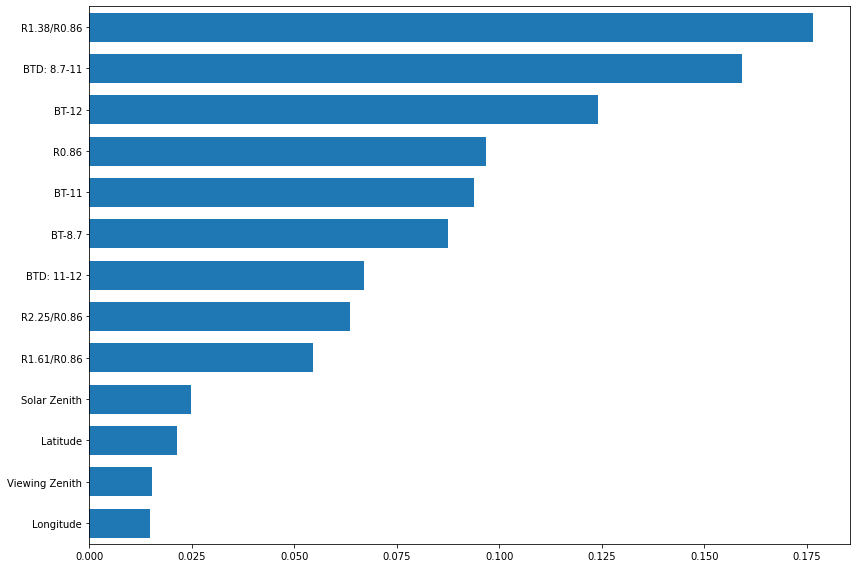

In [ ]:
# show feature importance:
feature_names = np.array(['Solar Zenith','Viewing Zenith', 'BT-8.7', 'BT-11', 'BT-12', 'BTD: 8.7-11', 'BTD: 11-12',
                 'R0.86','R1.38/R0.86','R1.61/R0.86','R2.25/R0.86','Latitude','Longitude'])
tree_importance_sorted_idx = np.argsort(rfforest.feature_importances_)
tree_indices = np.arange(0, len(rfforest.feature_importances_)) + 0.5
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
ax1.barh(tree_indices,
         rfforest.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(feature_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(rfforest.feature_importances_)))

fig.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 1.0, 'Liquid Water Cloud Probability Distribution')

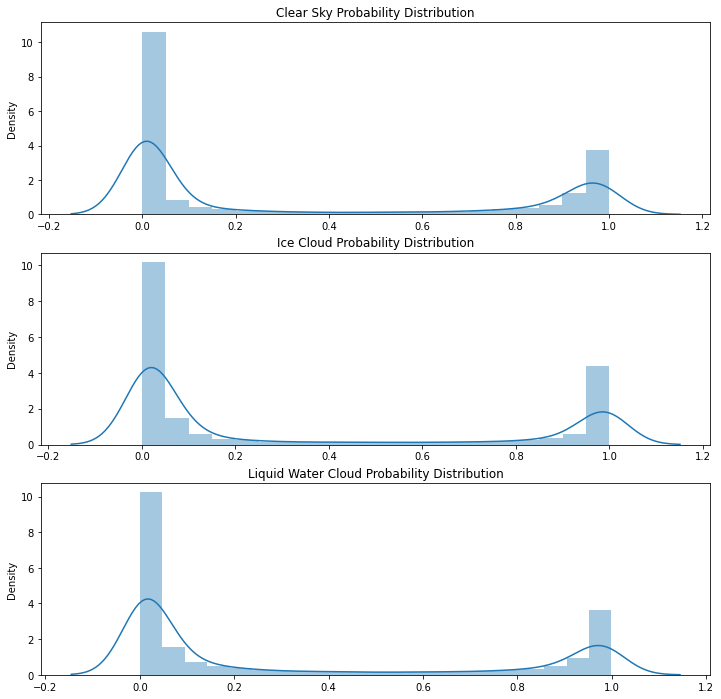

In [ ]:
#show probability distribution functions
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(12, 12))
sns.distplot(test_predict_YP[:,0],ax=ax1); # clear sky probability
sns.distplot(test_predict_YP[:,1],ax=ax2); # Ice Cloud probability
sns.distplot(test_predict_YP[:,2],ax=ax3); # Liquid Water Cloud probability
ax1.set_title('Clear Sky Probability Distribution')
ax2.set_title('Ice Cloud Probability Distribution')
ax3.set_title('Liquid Water Cloud Probability Distribution')

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, (ax1) = plt.subplots(1, 1, figsize=(8, 8))

    plt.imshow(cm, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=15)
    plt.yticks(tick_marks, classes, size=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black", size=15)

    plt.ylabel('True label',size=15)
    plt.xlabel('Predicted label',size=15)
    plt.ylim([-0.5,-0.5+len(classes)])
    plt.tight_layout()

Confusion matrix, without normalization
[[13374   275   526]
 [  559 12634   588]
 [  768   574 12042]]


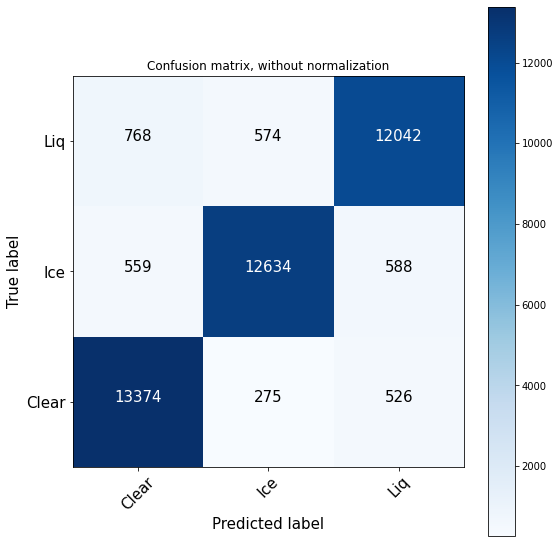

In [ ]:
#show confusion matrix
CM = confusion_matrix(test_Y, test_predict_Y)

plot_confusion_matrix(CM, classes=['Clear', 'Ice', 'Liq'],
                      title='Confusion matrix, without normalization')
plt.show()

